In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
train_dir = r'.\\images\\train'
val_dir = r'.\\images\\val'
test_dir = r'.\\images\\test'

In [11]:
# iamge data generator

train_gen = ImageDataGenerator(rescale=1./255,
                             vertical_flip=True,
                             #brightness_range= (0.20, 0.8),
                             zoom_range=0.1,
                             fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1./255,
                             vertical_flip=True,
                             #brightness_range= (0.20, 0.7),
                             zoom_range=0.1,
                             fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255,
                             fill_mode='nearest')

In [12]:
# build image data gen

train_data = train_gen.flow_from_directory(train_dir,
                                            batch_size=32,
                                            target_size=(64, 64), 
                                            class_mode='categorical')

val_data = val_gen.flow_from_directory(val_dir,
                                        batch_size=32,
                                        target_size=(64, 64),
                                        class_mode='categorical')

test_data = test_gen.flow_from_directory(test_dir,
                                        batch_size=32,
                                        target_size=(150, 150),
                                        class_mode='categorical')

Found 3612 images belonging to 7 classes.
Found 1202 images belonging to 7 classes.
Found 1202 images belonging to 7 classes.


# 2. Training

### proses

In [17]:
# model architecture
model = tf.keras.models.Sequential(
    [
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(64, 64, 3), activation=tfa.activations.mish, padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation=tfa.activations.mish, padding='same'), #1
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation=tfa.activations.mish, padding='same'),  #2
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tfa.activations.mish),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16, activation=tfa.activations.mish),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax')
    ]
)

model.compile(loss='categorical_crossentropy',
            optimizer=tfa.optimizers.RectifiedAdam(0.001),
            metrics=[
                    tf.keras.metrics.Precision(name="precision"),
                    tf.keras.metrics.Recall(name="recall"),
                    tf.keras.metrics.AUC(name="auc"),
                    tf.keras.metrics.AUC(name="prc", curve="PR"),
                ])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 16)      

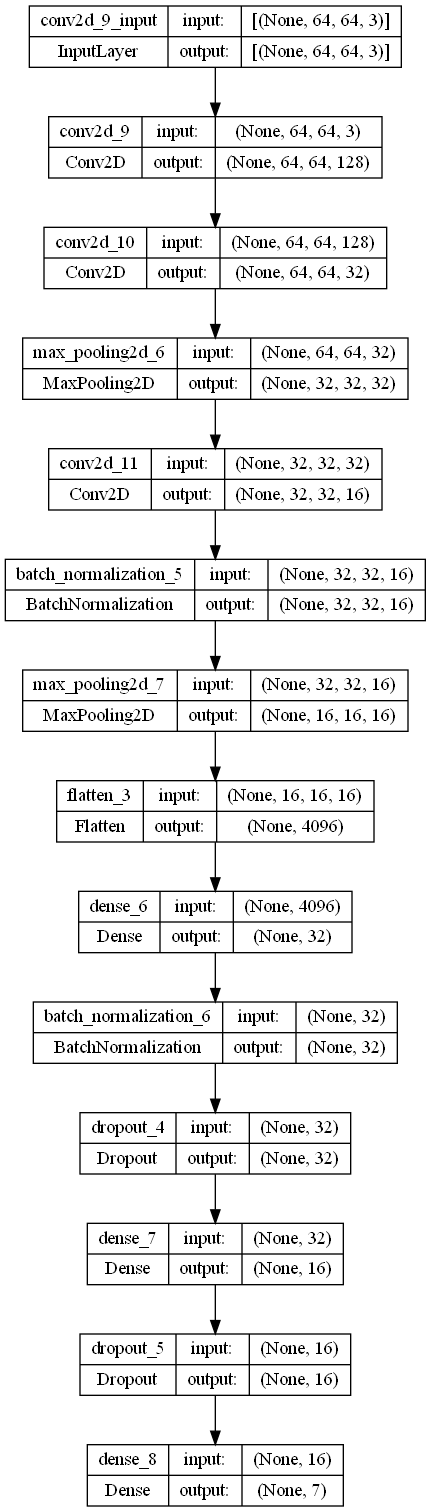

In [19]:
# plot model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='architecture.png', show_shapes=True)

In [ ]:
ckpt_path = r'.\\Checkpoints\\Nvidia4'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path,
                                                    save_weight_only=False,
                                                    mode='auto',
                                                    monitor='val_accuracy',
                                                    save_best_only=False,
                                                    verbose=0)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=8,
                    epochs=500,
                    validation_data=val_data,
                    validation_steps=3,
                    callbacks=[cp_callback],
                    verbose=1)

# 3. Evaluate model

### Try Evaluate001

In [9]:
model = tf.keras.models.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'), #1
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),  #2
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
    ]
)

# compiling model
model.compile(loss='categorical_crossentropy',
            optimizer=tf.optimizers.Adam(learning_rate=0.005),
            metrics=['accuracy'])


In [10]:
model.load_weights('./Checkpoints/Nvidia/')

### Evaluating

In [9]:
history = model.history

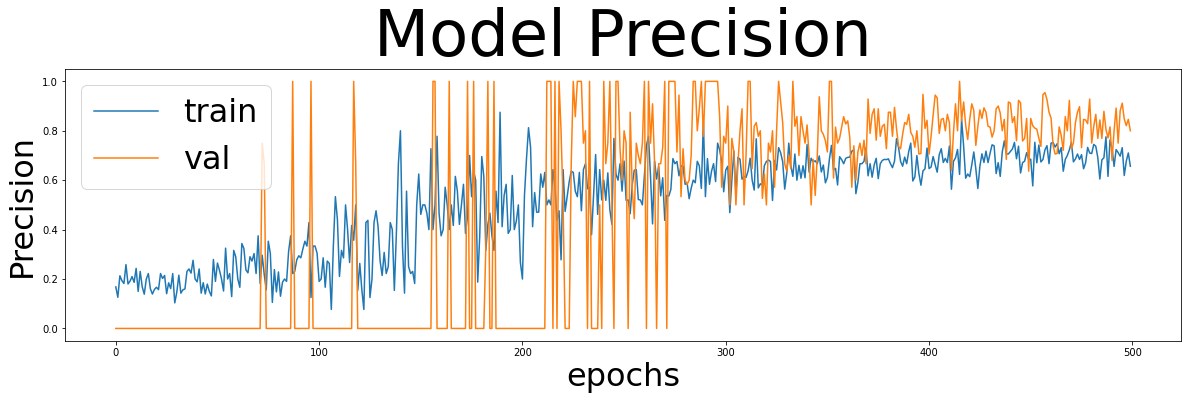

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.legend(['train', 'val'], loc='upper left', prop={'size':32})
plt.ylabel('Precision', fontsize=32)
plt.xlabel('epochs', fontsize=32)
plt.title('Model Precision', fontsize=64)
plt.show()

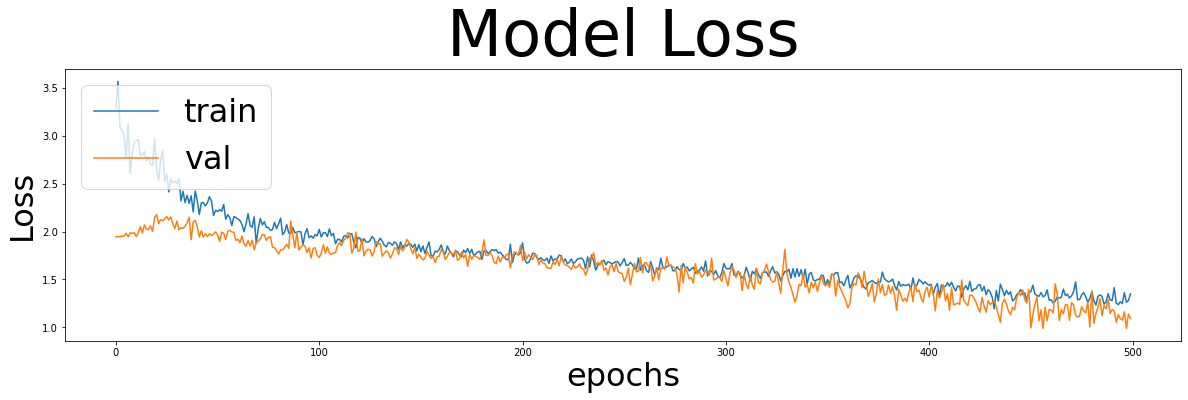

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left', prop={'size':32})
plt.ylabel('Loss', fontsize=32)
plt.xlabel('epochs', fontsize=32)
plt.title('Model Loss', fontsize=64)
plt.show()

In [31]:
from statistics import mean

print('Mean Loss: \t\t\t', mean(history.history['loss']))
print('Mean Validation Loss: \t\t', mean(history.history['val_loss']))
print('Mean Precision: \t\t', mean(history.history['precision']))
print('Mean Validation Precision: \t', mean(history.history['val_precision']))
print('Mean Recall: \t\t\t', mean(history.history['recall']))
print('Mean Validation Recall: \t', mean(history.history['val_recall']))

Mean Loss: 			 1.7416928417682647
Mean Validation Loss: 		 1.6036838309764863
Mean Precision: 		 0.5120468386858702
Mean Validation Precision: 	 0.4638850077390671
Mean Recall: 			 0.09939620546530932
Mean Validation Recall: 	 0.08483333325758577


In [32]:
import pandas as pd

dt = pd.DataFrame(history.history)

In [48]:
dt.head(10)

,loss,accuracy,val_loss,val_accuracy
0,2.389642,0.159226,26.317192,0.200000
1,2.095482,0.175595,10.626800,0.185714
2,1.969681,0.188988,4.212016,0.221429
3,1.903134,0.223214,2.882439,0.185714
4,1.885006,0.244048,2.229673,0.164286
5,1.859358,0.221726,2.224906,0.192857
6,1.844862,0.254464,1.874101,0.242857
7,1.866653,0.241071,1.855578,0.278571
8,1.846688,0.233631,1.827798,0.257143
9,1.844677,0.241071,1.866250,0.357143


In [33]:
dt.describe()

,loss,precision,recall,auc,prc,val_loss,val_precision,val_recall,val_auc,val_prc
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.741693,0.512047,0.099396,0.723039,0.345150,1.603684,0.463885,0.084833,0.744872,0.401855
std,0.381272,0.200898,0.081286,0.102029,0.129904,0.275940,0.413688,0.108972,0.123806,0.168468
min,1.191777,0.076923,0.003906,0.482586,0.139219,0.988283,0.000000,0.000000,0.407977,0.112611
25%,1.474162,0.331250,0.031250,0.639656,0.217996,1.382361,0.000000,0.000000,0.681984,0.258228
50%,1.665846,0.586801,0.070312,0.745125,0.346524,1.624985,0.666667,0.020833,0.768139,0.391434
75%,1.891143,0.675874,0.160792,0.811934,0.458830,1.804150,0.829762,0.156250,0.843169,0.545298
max,3.569237,0.875000,0.308594,0.888012,0.621872,2.179206,1.000000,0.406250,0.938657,0.768729


In [19]:
import json

json.dump(history.history, open('history.json', 'w'))

In [13]:
y_pred = model.predict(test_data)

38/38 [==============================] - 41s 888ms/step


In [16]:
y_pred = y_pred.argmax(axis=-1)

In [40]:
y_pred

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [6, 6, 6, ..., 6, 6, 6],
       [1, 1, 1, ..., 1, 1, 1]])

In [22]:
y_test = test_data.labels

In [23]:
y_test

array([0, 0, 0, ..., 6, 6, 6])

In [24]:
len(y_test)

1202

In [25]:
len(y_pred)

1202

In [45]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

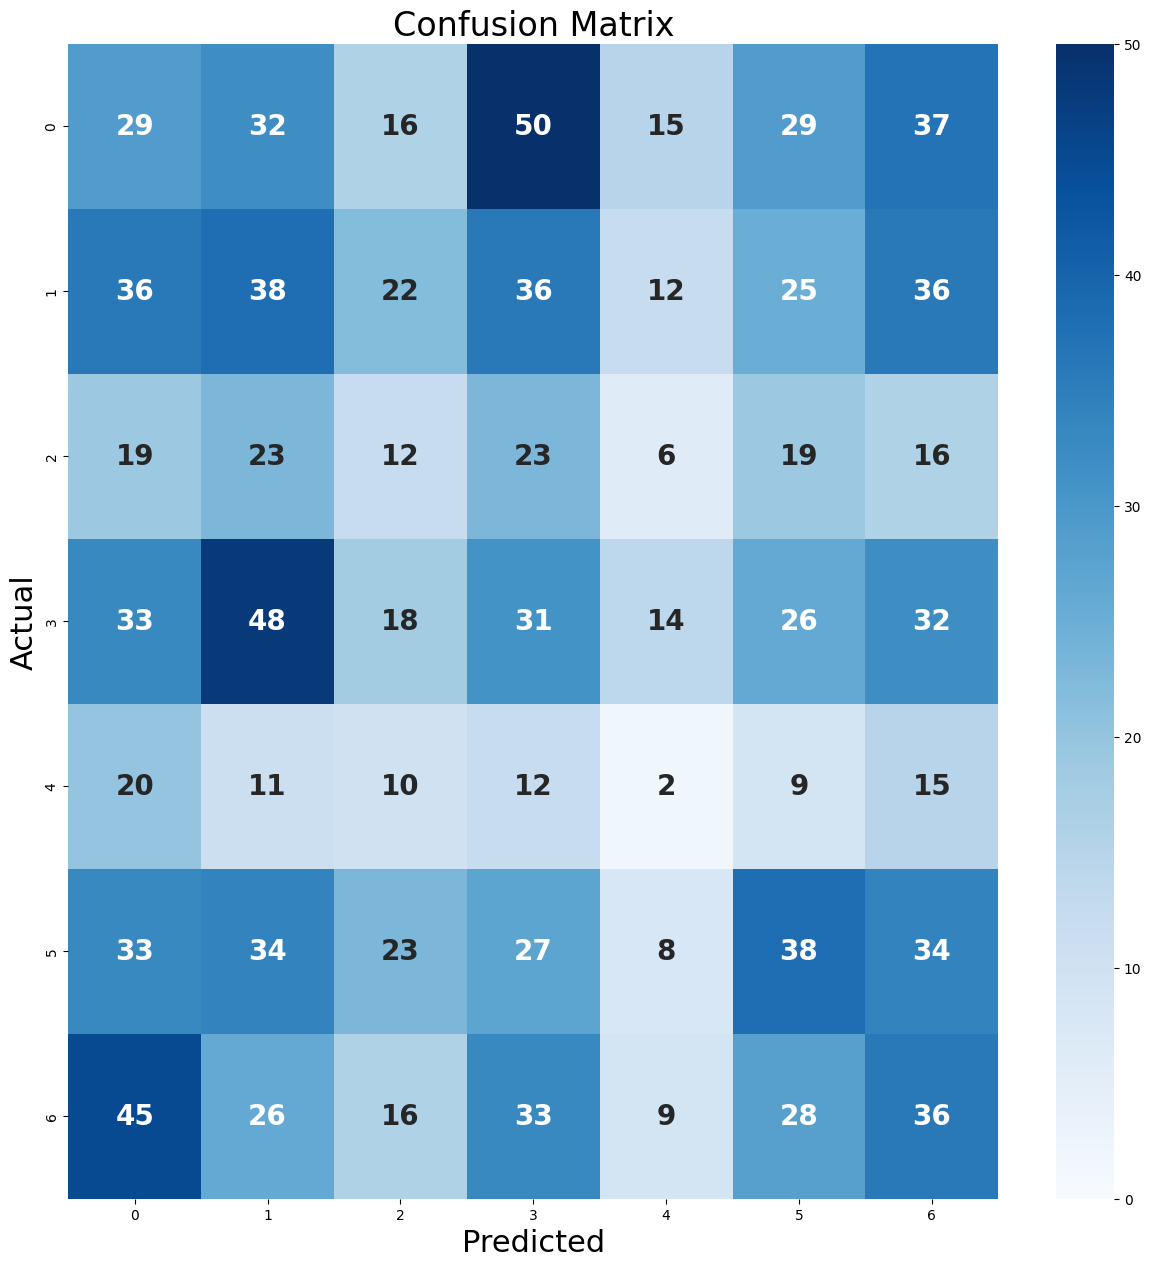

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['angry', 'confused', 'contemp', 'crying', 'disgust', 'sadness', 'smile']
cf = confusion_matrix(y_pred=y_pred, y_true=y_test)

plt.figure(figsize=(15, 15))
sns.heatmap(cf, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=True, annot_kws={
                'fontsize': 20,
                'fontweight': 'bold'
            }) 
'''plt.xticks(np.arange(len(class_names))+.5, class_names, rotation= 90, fontsize=14)
plt.yticks(np.arange(len(class_names))+.5, class_names, rotation=0, fontsize=14)'''
plt.xlabel("Predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)
plt.title("Confusion Matrix", fontsize=24)
plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

acc_model = accuracy_score(y_test, y_pred)*100
prec_model = precision_score(y_test, y_pred, average='weighted')*100
recall_model = recall_score(y_test, y_pred, average='weighted')*100
f1_model = f1_score(y_test, y_pred, average='weighted')*100

print("Model Evaluation")
print("model accuracy:   ", acc_model)
print('model precision:  ', prec_model)
print('model recall:     ', recall_model)
print('model f1-score:   ', f1_model)



Model Evaluation
model accuracy:    15.474209650582363
model precision:   15.439807001952527
model recall:      15.474209650582363
model f1-score:    15.436493310807212


In [32]:
#checkpoint_for_used = r'.\\Checkpoints\\Nvidia'
#model.load_weights(checkpoint_for_used)
result = model.evaluate(test_data)
result

38/38 [==============================] - 14s 365ms/step - loss: 0.3694 - accuracy: 0.9101


[0.3693898022174835, 0.9101497530937195]

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('Checkpoints/Nvidia2/')

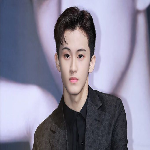

In [42]:
# open new image

img_test = tf.keras.utils.load_img('0001.jpg', target_size=(150, 150))
img_test

In [46]:
img_test_array = tf.keras.utils.img_to_array(img_test)
img_test_array = tf.expand_dims(img_test_array, axis=0)


In [47]:
from tensorflow.keras.applications.resnet50 import preprocess_input

img_test_array = preprocess_input(img_test_array)

In [48]:
test_img = model.predict(img_test_array)

1/1 [==============================] - 1s 609ms/step


In [49]:
test_img.argmax(axis=-1)

array([6], dtype=int64)

In [50]:
score_pred = tf.nn.softmax(test_img)

In [51]:
score_pred

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.1147015 , 0.1147015 , 0.1147015 , 0.1147015 , 0.1147015 ,
        0.1147015 , 0.31179097]], dtype=float32)>

This image most likely belongs to smile with a 31.18 percent confidence.


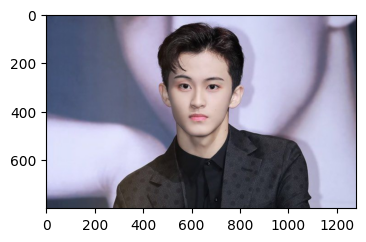

In [53]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['angry', 'confused', 'contemp', 'crying', 'disgust', 'sadness', 'smile']

x = plt.imread('0001.jpg')

plt.figure(figsize=(4, 5))
plt.imshow(x)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_pred)], 100 * np.max(score_pred))
)